In [0]:
from fastai.vision import *
from fastai.callbacks import *
from fastai.metrics import error_rate
import pandas as pd
import torch.nn as nn
import cv2
import concurrent
from tqdm import tqdm

In [0]:
from google.colab import drive, files, auth
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!wget https://www.dropbox.com/s/323l5shoq245mhw/images.zip
!unzip 'images.zip'

--2019-05-17 20:20:12--  https://www.dropbox.com/s/323l5shoq245mhw/images.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.1, 2620:100:6031:1::a27d:5101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/323l5shoq245mhw/images.zip [following]
--2019-05-17 20:20:12--  https://www.dropbox.com/s/raw/323l5shoq245mhw/images.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1ec73148ef8aba97f4b45e4a0e.dl.dropboxusercontent.com/cd/0/inline/AhH0fQpwkxBTb4mJz4tlFjICEjaEh_XEeylUl80K_On20EYW0jepzyBI_fJmUz6s8KLWCiXQHWHY3cShlaYz4pEGY5PVi8N84FmFWcmZz_b5aw/file# [following]
--2019-05-17 20:20:12--  https://uc1ec73148ef8aba97f4b45e4a0e.dl.dropboxusercontent.com/cd/0/inline/AhH0fQpwkxBTb4mJz4tlFjICEjaEh_XEeylUl80K_On20EYW0jepzyBI_fJmUz6s8KLWCiXQHWHY3cShlaYz4pEGY5PVi8N84FmFWcmZz_b5aw/file
Resolving uc1ec73148ef

In [0]:
batch_size = 32
img_size = 224

base = Path('images')
train = base/'train/'
occ = base/'people_crops/'
test = base/'test/'

# load data frames for training
data_df = pd.read_csv('/content/drive/My Drive/images/train_platform2.csv')
occ_df = pd.read_csv('/content/drive/My Drive/images/occlusions.csv')

# label_col = 0 # predict the chain_id
# fn_col = -1

def apply_occlusion(img, occlusion_idx=None, scale_resize=1., max_fill_percent=0.8):
    img_c, img_h, img_w = img.shape
    
    # load occlusion
    occ_idx = np.random.randint(len(occ_df)) if not occlusion_idx else occlusion_idx
    occ_path = occ_df.loc[occ_idx].path 
    occ = cv2.imread(occ_path)
    if occ is None: return img 

    # random resize taking up < `max_fill_percent`% of image 
    while True:
        resized_occ = cv2.resize(occ, (0, 0),
                               fx=max(np.random.uniform(low=0.1, high=0.7) * scale_resize, 0.4), 
                               fy=max(np.random.uniform(low=0.1, high=0.7) * scale_resize, 0.4))
        percent_filled = np.sum(resized_occ[:, :, 0] // 255) / (img_h * img_w)
        h, w, _ = resized_occ.shape
    
        if percent_filled < max_fill_percent and h < img_h and w < img_w: 
            occ_mask = (1 - resized_occ // 255)
            break
    
    
    occ_h, occ_w, _ = occ_mask.shape
    d_height = img_h - occ_h 
    d_width = img_w - occ_w
    
    # random placement 
    p_top = np.random.uniform() 
    p_left = np.random.uniform() 
    top_fill = int(d_height * p_top)
    bottom_fill = d_height - top_fill
    left_fill = int(d_width * p_left)
    right_fill = d_width - left_fill
    
    fit_occ_mask = cv2.copyMakeBorder(occ_mask, top_fill, bottom_fill, left_fill, right_fill, cv2.BORDER_CONSTANT)
    tensor_occ_mask = torch.from_numpy(1 - fit_occ_mask[:, :, 0]).type(torch.float)

    return tensor_occ_mask * img    
  
# apply occlusions to training images
def get_occlusion_trans(max_fill_percent=0.8):
  def _occlusion(x):
      x = apply_occlusion(x, max_fill_percent=max_fill_percent)
      return x
  return TfmPixel(_occlusion)

# add occlusions to the transformation
occ = get_occlusion_trans(max_fill_percent=0.8)
ds_tfms = get_transforms(max_rotate=35, max_zoom=1.4, max_lighting=0.2,
                         max_warp=0.4, p_affine=1.0, p_lighting=1.0,
                         xtra_tfms=[occ()])

# new databunch with occlusions
data = ImageDataBunch.from_df('/content/images/train/', 
                            data_df, 
                            label_col=-1,
                            fn_col=-2, 
                            ds_tfms=ds_tfms, 
                            size=img_size,
                            bs=batch_size)


# Training Helpers
def get_callbacks(learn, name):
  return [
      ReduceLROnPlateauCallback(learn),
      SaveModelCallback(learn, every='improvement', monitor='accuracy', name=name),
      EarlyStoppingCallback(learn, monitor='accuracy', patience=3)
  ]

def stage1(learn, name, n_cycles=5, lr=3e-3):
  learn.fit_one_cycle(n_cycles, slice(lr), callbacks=get_callbacks(learn, name))
  learn.save('end-stage1-{}'.format(name))

def stage2(learn, name, n_cycles=5, lr=3e-3):
  learn.unfreeze()
  lrs = slice(lr/100, lr)
  learn.fit_one_cycle(n_cycles, lrs, pct_start=0.5, callbacks=get_callbacks(learn, name))
  learn.save('end-stage2-{}'.format(name))

def view(learn):
  interp1 = ClassificationInterpretation.from_learner(learn)
  interp1.plot_confusion_matrix()

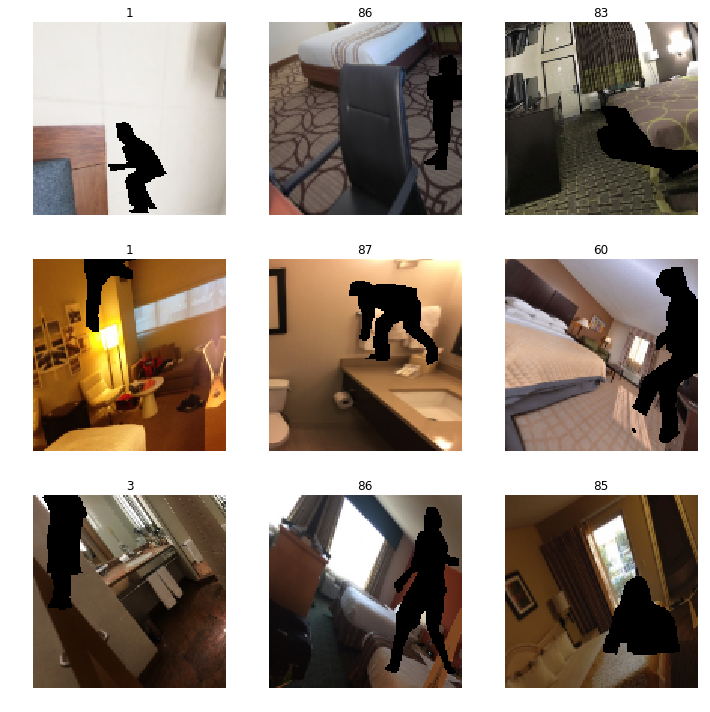

In [0]:
data.show_batch(rows=3, figsize=(10, 10))

In [0]:
learn = cnn_learner(data, models.resnet101, metrics=[error_rate, accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


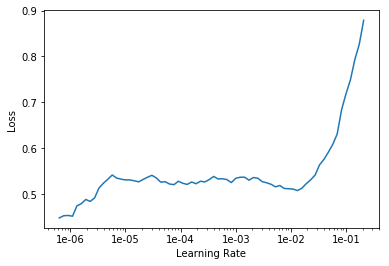

In [15]:
lr_find(learn)
learn.recorder.plot()

In [16]:
stage1(learn, 'resnet101', n_cycles=10, lr=1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.506764,0.413384,0.144444,0.855556,00:26
1,0.520870,0.399352,0.138889,0.861111,00:25
2,0.505258,0.411509,0.150000,0.850000,00:24
3,0.497670,0.398571,0.150000,0.850000,00:25
4,0.491759,0.403148,0.138889,0.861111,00:24


Better model found at epoch 0 with accuracy value: 0.855555534362793.
Better model found at epoch 1 with accuracy value: 0.8611111044883728.
Epoch 2: reducing lr to 2e-05
Epoch 4: reducing lr to 1.6234913078995263e-05
Epoch 5: reducing lr to 1.2225240438725786e-05
Epoch 5: early stopping


In [17]:
stage2(learn, 'resnet101', n_cycles=10, lr=1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.564173,0.399016,0.133333,0.866667,00:26
1,0.529468,0.390780,0.138889,0.861111,00:26
2,0.531489,0.402127,0.144444,0.855556,00:25
3,0.505073,0.393596,0.155556,0.844444,00:27


Better model found at epoch 0 with accuracy value: 0.8666666746139526.
Epoch 2: reducing lr to 1.3366563145999493e-05
Epoch 3: reducing lr to 1.8166563145999493e-05
Epoch 4: early stopping


In [0]:
test_df = pd.read_csv('/content/drive/My Drive/images/test_platform.csv')

In [23]:
len(test_df)

100

In [0]:
test_data = ImageDataBunch.from_df('images/train/', 
                            test_df, 
                            label_col=1,
                            fn_col=-1, 
                            size=img_size,
                            bs=batch_size)

In [20]:
learn.validate(test_data.dl())

[0.5003719, tensor(0.2000), tensor(0.8000)]

In [27]:
learn.metrics

[<function fastai.metrics.error_rate>, <function fastai.metrics.accuracy>]

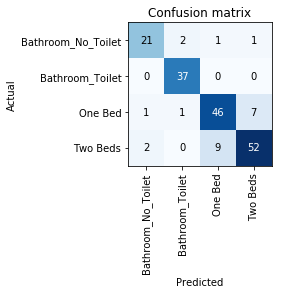

In [28]:
interp = view(learn)

In [29]:
interp.plot_top_losses(50, largest=False, figsize=(50, 50))

AttributeError: ignored

In [0]:
from google.colab import files

save_name = 'resnet101-final'
learn.save(save_name)
files.download('/models/{}.pth'.format(save_name))

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 39230, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil